 # Test RippleNet Result

In [1]:
TEST_CODE = "1561463864.044628"
CHOSEN_EPOCH = 6

MODEL_PATH = "../log/{}/models/epoch_{}".format(TEST_CODE, CHOSEN_EPOCH)
LOG_PATH = "../log/{}/log.txt".format(TEST_CODE)

In [2]:
from ipywidgets import FloatProgress, IntProgress
from IPython.display import display
from tqdm import tqdm

In [3]:
# Logger.py

import pickle
import os

class Logger:

    def set_default_filename(self, filename):
        self.default_filename = filename

    def create_session_folder(self, path):
        try:  
            os.makedirs(path)
        except OSError:  
            print ("Creation of the directory %s failed" % path)
        else:  
            print ("\n ===> Successfully created the directory %s \n" % path)

    def log(self, text):
        with open(self.default_filename, 'a') as f:
            f.writelines(text)
            f.write("\n")

    def save_model(self, model, filename):
        pickle.dump(model, open(filename, 'wb'))
    
    

In [4]:
# Model.py

import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score


class RippleNet(object):
    def __init__(self, args, n_entity, n_relation):
        self._parse_args(args, n_entity, n_relation)
        self._build_inputs()
        self._build_embeddings()
        self._build_model()
        self._build_loss()
        self._build_train()

    def _parse_args(self, args, n_entity, n_relation):
        self.n_entity = n_entity
        self.n_relation = n_relation
        self.dim = args.dim
        self.n_hop = args.n_hop
        self.kge_weight = args.kge_weight
        self.l2_weight = args.l2_weight
        self.lr = args.lr
        self.n_memory = args.n_memory
        self.item_update_mode = args.item_update_mode
        self.using_all_hops = args.using_all_hops

    def _build_inputs(self):
        self.items = tf.placeholder(dtype=tf.int32, shape=[None], name="items")
        self.labels = tf.placeholder(dtype=tf.float64, shape=[None], name="labels")
        self.memories_h = []
        self.memories_r = []
        self.memories_t = []

        for hop in range(self.n_hop):
            self.memories_h.append(
                tf.placeholder(dtype=tf.int32, shape=[None, self.n_memory], name="memories_h_" + str(hop)))
            self.memories_r.append(
                tf.placeholder(dtype=tf.int32, shape=[None, self.n_memory], name="memories_r_" + str(hop)))
            self.memories_t.append(
                tf.placeholder(dtype=tf.int32, shape=[None, self.n_memory], name="memories_t_" + str(hop)))

    def _build_embeddings(self):
        self.entity_emb_matrix = tf.get_variable(name="entity_emb_matrix", dtype=tf.float64,
                                                 shape=[self.n_entity, self.dim],
                                                 initializer=tf.contrib.layers.xavier_initializer())
        self.relation_emb_matrix = tf.get_variable(name="relation_emb_matrix", dtype=tf.float64,
                                                   shape=[self.n_relation, self.dim, self.dim],
                                                   initializer=tf.contrib.layers.xavier_initializer())

    def _build_model(self):
        # transformation matrix for updating item embeddings at the end of each hop
        self.transform_matrix = tf.get_variable(name="transform_matrix", shape=[self.dim, self.dim], dtype=tf.float64,
                                                initializer=tf.contrib.layers.xavier_initializer())

        # [batch size, dim]
        self.item_embeddings = tf.nn.embedding_lookup(self.entity_emb_matrix, self.items)

        self.h_emb_list = []
        self.r_emb_list = []
        self.t_emb_list = []
        for i in range(self.n_hop):
            # [batch size, n_memory, dim]
            self.h_emb_list.append(tf.nn.embedding_lookup(self.entity_emb_matrix, self.memories_h[i]))

            # [batch size, n_memory, dim, dim]
            self.r_emb_list.append(tf.nn.embedding_lookup(self.relation_emb_matrix, self.memories_r[i]))

            # [batch size, n_memory, dim]
            self.t_emb_list.append(tf.nn.embedding_lookup(self.entity_emb_matrix, self.memories_t[i]))

        o_list = self._key_addressing()

        self.scores = tf.squeeze(self.predict(self.item_embeddings, o_list))
        self.scores_normalized = tf.sigmoid(self.scores)

    def _key_addressing(self):
        o_list = []
        for hop in range(self.n_hop):
            # [batch_size, n_memory, dim, 1]
            h_expanded = tf.expand_dims(self.h_emb_list[hop], axis=3)

            # [batch_size, n_memory, dim]
            Rh = tf.squeeze(tf.matmul(self.r_emb_list[hop], h_expanded), axis=3)

            # [batch_size, dim, 1]
            v = tf.expand_dims(self.item_embeddings, axis=2)

            # [batch_size, n_memory]
            probs = tf.squeeze(tf.matmul(Rh, v), axis=2)

            # [batch_size, n_memory]
            probs_normalized = tf.nn.softmax(probs)

            # [batch_size, n_memory, 1]
            probs_expanded = tf.expand_dims(probs_normalized, axis=2)

            # [batch_size, dim]
            o = tf.reduce_sum(self.t_emb_list[hop] * probs_expanded, axis=1)

            self.item_embeddings = self.update_item_embedding(self.item_embeddings, o)
            o_list.append(o)
        return o_list

    def update_item_embedding(self, item_embeddings, o):
        if self.item_update_mode == "replace":
            item_embeddings = o
        elif self.item_update_mode == "plus":
            item_embeddings = item_embeddings + o
        elif self.item_update_mode == "replace_transform":
            item_embeddings = tf.matmul(o, self.transform_matrix)
        elif self.item_update_mode == "plus_transform":
            item_embeddings = tf.matmul(item_embeddings + o, self.transform_matrix)
        else:
            raise Exception("Unknown item updating mode: " + self.item_update_mode)
        return item_embeddings

    def predict(self, item_embeddings, o_list):
        y = o_list[-1]
        if self.using_all_hops:
            for i in range(self.n_hop - 1):
                y += o_list[i]

        # [batch_size]
        scores = tf.reduce_sum(item_embeddings * y, axis=1)
        return scores

    def _build_loss(self):
        self.base_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=self.scores))

        self.kge_loss = 0
        for hop in range(self.n_hop):
            h_expanded = tf.expand_dims(self.h_emb_list[hop], axis=2)
            t_expanded = tf.expand_dims(self.t_emb_list[hop], axis=3)
            hRt = tf.squeeze(tf.matmul(tf.matmul(h_expanded, self.r_emb_list[hop]), t_expanded))
            self.kge_loss += tf.reduce_mean(tf.sigmoid(hRt))
        self.kge_loss = -self.kge_weight * self.kge_loss

        self.l2_loss = 0
        for hop in range(self.n_hop):
            self.l2_loss += tf.reduce_mean(tf.reduce_sum(self.h_emb_list[hop] * self.h_emb_list[hop]))
            self.l2_loss += tf.reduce_mean(tf.reduce_sum(self.t_emb_list[hop] * self.t_emb_list[hop]))
            self.l2_loss += tf.reduce_mean(tf.reduce_sum(self.r_emb_list[hop] * self.r_emb_list[hop]))
            if self.item_update_mode == "replace nonlinear" or self.item_update_mode == "plus nonlinear":
                self.l2_loss += tf.nn.l2_loss(self.transform_matrix)
        self.l2_loss = self.l2_weight * self.l2_loss

        self.loss = self.base_loss + self.kge_loss + self.l2_loss

    def _build_train(self):
        self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        '''
        optimizer = tf.train.AdamOptimizer(self.lr)
        gradients, variables = zip(*optimizer.compute_gradients(self.loss))
        gradients = [None if gradient is None else tf.clip_by_norm(gradient, clip_norm=5)
                     for gradient in gradients]
        self.optimizer = optimizer.apply_gradients(zip(gradients, variables))
        '''

    def train(self, sess, feed_dict):
        return sess.run([self.optimizer, self.loss], feed_dict)

    def eval(self, sess, feed_dict):
        labels, scores = sess.run([self.labels, self.scores_normalized], feed_dict)
        auc = roc_auc_score(y_true=labels, y_score=scores)
        predictions = [1 if i >= 0.5 else 0 for i in scores]
        acc = np.mean(np.equal(predictions, labels))
        return auc, acc
  
    # ============ Custom test purpose ============
    def custom_eval(self, sess, feed_dict):
        labels, scores = sess.run([self.labels, self.scores_normalized], feed_dict)
        auc = roc_auc_score(y_true=labels, y_score=scores)
        predictions = [1 if i >= 0.5 else 0 for i in scores]
        acc = np.mean(np.equal(predictions, labels))
        return auc, acc, labels, scores, predictions
    

In [5]:
# Dataloader.py

import collections
import os
import numpy as np


def load_data(args):
    train_data, eval_data, test_data, user_history_dict = load_rating(args)
    n_entity, n_relation, kg = load_kg(args)
    ripple_set = get_ripple_set(args, kg, user_history_dict)
    return train_data, eval_data, test_data, n_entity, n_relation, ripple_set

def load_rating(args):
    print('reading rating file ...')

    # reading rating file
    rating_file = '../data/' + args.dataset + '/ratings_final'
    if os.path.exists(rating_file + '.npy'):
        rating_np = np.load(rating_file + '.npy')
    else:
        rating_np = np.loadtxt(rating_file + '.txt', dtype=np.int32)
        np.save(rating_file + '.npy', rating_np)

    return dataset_split(rating_np)


def dataset_split(rating_np):
    print('splitting dataset ...')

    # train:eval:test = 6:2:2
    eval_ratio = 0.2
    test_ratio = 0.2
    n_ratings = rating_np.shape[0]

    eval_indices = np.random.choice(n_ratings, size=int(n_ratings * eval_ratio), replace=False)
    left = set(range(n_ratings)) - set(eval_indices)
    test_indices = np.random.choice(list(left), size=int(n_ratings * test_ratio), replace=False)
    train_indices = list(left - set(test_indices))
    # print(len(train_indices), len(eval_indices), len(test_i  ndices))

    # traverse training data, only keeping the users with positive ratings
    user_history_dict = dict()
    for i in train_indices:
        user = rating_np[i][0]
        item = rating_np[i][1]
        rating = rating_np[i][2]
        if rating == 1:
            if user not in user_history_dict:
                user_history_dict[user] = []
            user_history_dict[user].append(item)

    train_indices = [i for i in train_indices if rating_np[i][0] in user_history_dict]
    eval_indices = [i for i in eval_indices if rating_np[i][0] in user_history_dict]
    test_indices = [i for i in test_indices if rating_np[i][0] in user_history_dict]
    # print(len(train_indices), len(eval_indices), len(test_indices))

    train_data = rating_np[train_indices]
    eval_data = rating_np[eval_indices]
    test_data = rating_np[test_indices]

    return train_data, eval_data, test_data, user_history_dict



def load_kg(args):
    print('reading KG file ...')

    # reading kg file
    kg_file = '../data/' + args.dataset + '/kg_final'
    if os.path.exists(kg_file + '.npy'):
        kg_np = np.load(kg_file + '.npy')
    else:
        kg_np = np.loadtxt(kg_file + '.txt', dtype=np.int32)
        np.save(kg_file + '.npy', kg_np)

    n_entity = len(set(kg_np[:, 0]) | set(kg_np[:, 2]))
    n_relation = len(set(kg_np[:, 1]))

    kg = construct_kg(kg_np)

    return n_entity, n_relation, kg


def construct_kg(kg_np):
    print('constructing knowledge graph ...')
    kg = collections.defaultdict(list)
    for head, relation, tail in kg_np:
        kg[head].append((tail, relation))
    return kg


def get_ripple_set(args, kg, user_history_dict):
    print('constructing ripple set ...')

    # user -> [(hop_0_heads, hop_0_relations, hop_0_tails), (hop_1_heads, hop_1_relations, hop_1_tails), ...]
    ripple_set = collections.defaultdict(list)

    for user in tqdm(user_history_dict):
        for h in range(args.n_hop):
            memories_h = []
            memories_r = []
            memories_t = []

            if h == 0:
                tails_of_last_hop = user_history_dict[user]
            else:
                tails_of_last_hop = ripple_set[user][-1][2]

            for entity in tails_of_last_hop:
                for tail_and_relation in kg[entity]:
                    memories_h.append(entity)
                    memories_r.append(tail_and_relation[1])
                    memories_t.append(tail_and_relation[0])

            # if the current ripple set of the given user is empty, we simply copy the ripple set of the last hop here
            # this won't happen for h = 0, because only the items that appear in the KG have been selected
            # this only happens on 154 users in Book-Crossing dataset (since both BX dataset and the KG are sparse)
            if len(memories_h) == 0:
                ripple_set[user].append(ripple_set[user][-1])
            else:
                # sample a fixed-size 1-hop memory for each user
                replace = len(memories_h) < args.n_memory
                indices = np.random.choice(len(memories_h), size=args.n_memory, replace=replace)
                memories_h = [memories_h[i] for i in indices]
                memories_r = [memories_r[i] for i in indices]
                memories_t = [memories_t[i] for i in indices]
                ripple_set[user].append((memories_h, memories_r, memories_t))

    return ripple_set


In [6]:
# Train.py

def get_feed_dict(args, model, data, ripple_set, start, end):
    feed_dict = dict()
    feed_dict[model.items] = data[start:end, 1]
    feed_dict[model.labels] = data[start:end, 2]
    for i in range(args.n_hop):
        feed_dict[model.memories_h[i]] = [ripple_set[user][i][0] for user in data[start:end, 0]]
        feed_dict[model.memories_r[i]] = [ripple_set[user][i][1] for user in data[start:end, 0]]
        feed_dict[model.memories_t[i]] = [ripple_set[user][i][2] for user in data[start:end, 0]]
    return feed_dict

def evaluation(sess, args, model, data, ripple_set, batch_size):
    start = 0
    auc_list = []
    acc_list = []
    while start < data.shape[0]:
        auc, acc = model.eval(sess, get_feed_dict(args, model, data, ripple_set, start, start + batch_size))
        auc_list.append(auc)
        acc_list.append(acc)
        start += batch_size
    return float(np.mean(auc_list)), float(np.mean(acc_list))

# Args

In [11]:
class Args:
    
    def __init__(self):
        self.dataset = 'movie'
        self.dim = 32
        self.n_hop = 2 
        self.kge_weight = 0.1
        self.l2_weight = 0.01
        self.lr = 0.005
        self.batch_size = 1024
        self.n_epoch = 50
        self.n_memory = 64
        self.item_update_mode = 'plus_transform'
        self.using_all_hops = True

args=Args()

## Load the knowledge graph

In [8]:
# Main.py

import numpy as np
# from Library.RippleNet.src.data_loader import load_data

np.random.seed(555)
show_loss = True

In [12]:
preprocessed_data_filename = "../data/movie/preprocessed_data_info_{}".format(args.n_memory)

try:
    data_info = pickle.load(open(preprocessed_data_filename, 'rb'))
except:
    data_info = load_data(args)
    pickle.dump(data_info, open(preprocessed_data_filename, 'wb'))

In [13]:
# Limit GPU usage
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

# Testing the model

Separate the preprocessed data

In [14]:
train_data = data_info[0]
eval_data = data_info[1]
test_data = data_info[2]
n_entity = data_info[3]
n_relation = data_info[4]
ripple_set = data_info[5]

# Evaluate 

In [16]:
model = RippleNet(args, n_entity, n_relation)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [19]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

sess = tf.Session(config=config)
saver = tf.train.import_meta_graph(MODEL_PATH + ".meta")
saver.restore(sess, MODEL_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../log/1561463864.044628/models/epoch_6


## Custom precision at K eval

In [20]:
truth_dict = {}
for rating in tqdm(train_data):
    user_id, movie_id, score = rating
    
    if user_id not in truth_dict:
        truth_dict[user_id] = []
    
    if score == 1:
        truth_dict[user_id].append(movie_id)
        
for rating in tqdm(test_data):
    user_id, movie_id, score = rating
    
    if user_id not in truth_dict:
        truth_dict[user_id] = []
    
    if score == 1:
        truth_dict[user_id].append(movie_id)
        
for rating in tqdm(eval_data):
    user_id, movie_id, score = rating
    
    if user_id not in truth_dict:
        truth_dict[user_id] = []
    
    if score == 1:
        truth_dict[user_id].append(movie_id)

100%|██████████| 2744582/2744582 [00:06<00:00, 407145.29it/s]


## Check user - num of rating dist

In [21]:
from collections import Counter

ns = []
for key in truth_dict:
    n = len(truth_dict[key])
    ns.append(n)

ns = Counter(ns)

In [22]:
nscum = {}
last = 0
for k in ns:
    nscum[k] = ns[k] + last
    last = nscum[k]

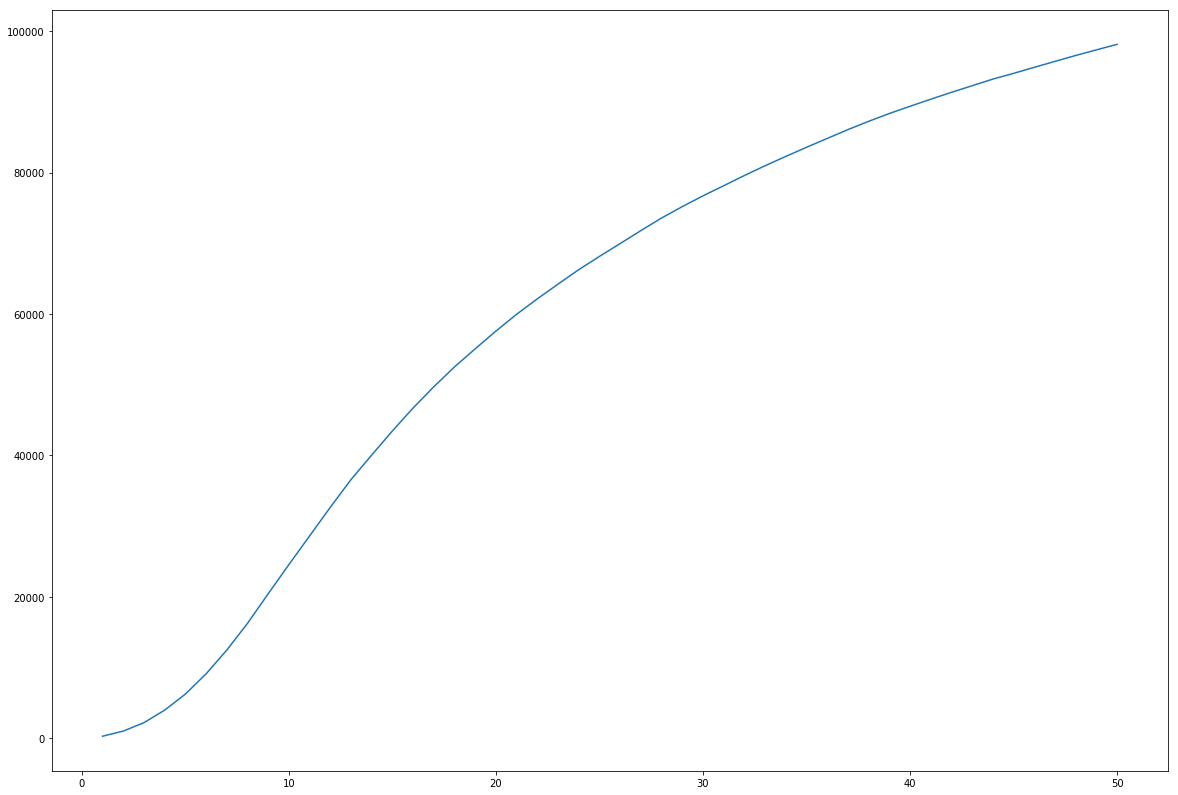

In [26]:
import matplotlib.pyplot as plt

# cummulative plot
plt.figure(figsize=(20,14))
plt.plot(list(nscum.keys())[:50], list(nscum.values())[:50])

### ==============

In [24]:
def create_cust_test_data(users, items):
    dummy_value = True
    cust_test_data = []
    
    for user in users:
        for item in items:
            x = [user, item, int(dummy_value)]
            cust_test_data.append(x)
            dummy_value = not(dummy_value)
            
    return np.array(cust_test_data)

def predict(sess, args, model, users, items):
    
    cust_test_data = create_cust_test_data(users, items)   
    
    scores = []
    for i in range(0, len(cust_test_data), args.batch_size):
        feed_dict = get_feed_dict(args, model, cust_test_data, ripple_set, i, i + args.batch_size)
        auc, acc, labels, batch_scores, predictions = model.custom_eval(sess, feed_dict)
        scores = np.concatenate((scores, batch_scores))
    
    return scores

In [25]:
def get_top_suggestion(user, k):
    
    items = [i for i in range(0, 15532)]
    prediction = predict(sess, args, model, [user], items)
    
    recommend = [(prediction[i], i) for i in items]
    recommend = sorted(recommend, reverse=True)[:k]
    
    return recommend
#     return [x[1] for x in recommend]

def get_top_truth(user, k):
    if user not in truth_dict:
        return []
    return truth_dict[user][:k]

In [29]:
def get_intersect_pred_truth(pred, truth, k):
    pred_item_set = {x[1] for x in pred}
    truth_item_set = set(truth)
    
    return pred_item_set.intersection(truth_item_set)

def check_precision_at_k(sample_user, k):
    
    pred = get_top_suggestion(sample_user, k)
    truth = get_top_truth(sample_user, k)
    
    intersect = get_intersect_pred_truth(pred, truth, k)
    
    if len(truth) > 0 :
        return intersect, len(intersect) / len(truth)
    else:
        return {}, 0

In [30]:
prec = []
intersect = []

for i in tqdm(range(5250, 5500)):
    
    try:
        isec, p = check_precision_at_k(i, 10)
    except Exception as e:
        p = 0
        isec = {}
        print("error occur for {} : {}".format(i, e))
        
    prec.append(p)
    intersect.append(isec)

  7%|▋         | 17/250 [00:26<05:25,  1.40s/it]

error occur for 5267 : list index out of range


 20%|██        | 51/250 [01:13<04:32,  1.37s/it]

error occur for 5301 : list index out of range


100%|██████████| 250/250 [05:52<00:00,  1.35s/it]


In [31]:
import numpy as np

np.average(prec)

0.0

## Check suggestion diversity

In [34]:
offset = 0 # discard top n suggestion
k = 10

sample_user = [np.random.randint(1, 15000) for i in range(0, k)]

intersect = {x[1] for x in get_top_suggestion(sample_user[0], k + offset)[offset:]}
uni = intersect
for i in range(1, 10):
    s = {x[1] for x in get_top_suggestion(sample_user[i], k + offset)[offset:]}
    print(sorted(s))
    intersect = intersect.intersection(s)
    uni = uni.union(s)
    
print("\nintersect")
print(intersect, len(intersect))
print("\nunion")
print(uni, len(uni))
print("\ndistinct rate")
print((len(uni)) / (10*k))

[2174, 2933, 3233, 5700, 7445, 10129, 11951, 12923, 13360, 13760]
[51, 554, 10056, 11621, 12923, 13149, 13425, 14956, 15329, 15375]
[51, 2933, 3865, 7445, 9916, 10416, 11621, 12923, 13308, 13360]
[554, 1314, 5700, 6443, 6566, 7498, 10129, 11913, 13760, 14352]
[554, 1016, 1314, 5538, 5697, 5700, 10129, 13308, 13760, 14485]
[554, 10056, 11066, 11621, 12923, 13149, 13425, 14010, 14956, 15329]
[51, 2770, 2933, 3865, 7445, 10056, 10700, 11621, 12923, 14956]
[554, 10029, 11066, 12923, 13149, 13425, 14010, 14956, 15329, 15375]
[51, 974, 4865, 8240, 9916, 12610, 13308, 13360, 14177, 14197]

intersect
set() 0

union
{4865, 11913, 15375, 14352, 10129, 7445, 14485, 3865, 3233, 1314, 5538, 6566, 554, 6443, 10029, 11951, 13360, 10416, 8240, 51, 14010, 11066, 9916, 13760, 5697, 12610, 5700, 10056, 7498, 10700, 9549, 974, 2770, 13149, 15329, 14177, 4068, 11621, 14956, 13425, 2933, 14197, 1016, 12923, 13308, 2174} 46

distinct rate
0.46


# ================

In [28]:
# sample_user = [932, 12949, 11028, 4721, 4828, 8842, 2919, 1837, 6260, 2582]
sample_user = [np.random.randint(1, 15000) for i in range(0, 10)]
offset = int(138493 * 0.9)
sample_user = [i + offset for i in sample_user]

In [ ]:
for user in sample_user:
    prediction = get_top_suggestion(user, 10)
    truth = get_top_truth(user, 10)
    
    display((prediction))
    display((truth))
    display(check_precision_at_k(user, 10))
    display("==================")